In [3]:
# run as the very first cell
import sys, pathlib

# If the notebook lives in sde_sampler_lrds/notebooks
repo_root = pathlib.Path.cwd().parent  # notebooks/ -> repo root
# If your notebook is elsewhere: set repo_root explicitly
# repo_root = pathlib.Path("/absolute/path/to/sde_sampler_lrds")

# 1) Put the repo root (which contains `sde_sampler/`) on sys.path
sys.path.insert(0, str(repo_root))

# 2) Try importing
import sde_sampler, inspect
print("Loaded from:", inspect.getsourcefile(sde_sampler))

Loaded from: /Users/kimhyunbin/Desktop/📚Uni Stuff/FYP/sde_sampler_lrds/sde_sampler/__init__.py


In [4]:
# Libraries
import torch
import matplotlib.pyplot as plt
from sde_sampler.additions.hacking import TrainableWrapper

In [5]:
# Pytorch device
device = torch.device('cpu')

Build the model targeting the `two_modes` target with the `vp_rds` solver and the `ei_reference_sde_lv` loss. Note that we use the `basic` control parametrization with doesn't depend on the score of the target distribution.

In [24]:
# Load the right configuration
from hydra import initialize, compose
from hydra.utils import instantiate
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(overrides=["+target=many_modes", "+solver=vp_rds", "loss=ei_reference_sde_lv", "model@generative_ctrl=basic"])
    cfg['train_steps'] = 256
    cfg['train_batch_size'] = 1024
    cfg['eval_batch_size'] = 8192
model = instantiate(cfg.solver, cfg)
model.setup()

Define the score of the target distribution

In [25]:
# Build the target's score
def target_log_prob_and_grad(y):
    y_ = torch.autograd.Variable(y.clone(), requires_grad=True)
    log_prob_y = model.target.log_prob(y_)
    return log_prob_y.flatten(), torch.autograd.grad(log_prob_y.sum(), y_)[0].detach()

Sample the target distribution with MCMC initialized at the mode locations

In [26]:
# Sample the target distribution with MCMC
from tqdm import trange
from sde_sampler.additions.mcmc import mala_step, heuristics_step_size
n_chains = 256
step_size = 1e-3 * torch.ones((n_chains, 1), device=device)
y_init = torch.concat([
    model.target.loc[0].unsqueeze(0).expand((n_chains // 2, -1)),
    model.target.loc[1].unsqueeze(0).expand((n_chains // 2, -1))
], dim=0)
y = torch.autograd.Variable(y_init.clone(), requires_grad=True)
target_log_prob_y, target_grad_y = target_log_prob_and_grad(y)
ys = [y.clone().detach().cpu()]
for _ in trange(2048):
    # Run MALA step
    y, target_log_prob_y, target_grad_y, log_acc = mala_step(
        y=y,
        target_log_prob_y=target_log_prob_y,
        target_grad_y=target_grad_y,
        target_log_prob_and_grad=target_log_prob_and_grad,
        step_size=step_size
    )
    # Adapt the step size
    step_size = heuristics_step_size(step_size, log_acc)
    # Save the step
    ys.append(y.detach().clone().cpu())
ys = torch.stack(ys)

100%|██████████| 2048/2048 [00:00<00:00, 3172.70it/s]


Fit a Gaussian Mixture Model

In [27]:
# Fit a GMM model
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(
    n_components=model.target.loc.shape[0],
    covariance_type='diag',
    means_init=model.target.loc.cpu().numpy()
)
gmm = gmm.fit(ys.view((-1, ys.shape[-1])).numpy())

Set the reference of the RDS model

In [28]:
# Change the reference process
model.change_reference_type(
    ref_type='gmm',
    weights=torch.from_numpy(gmm.weights_).to(device),
    means=torch.from_numpy(gmm.means_).to(device),
    variances=torch.from_numpy(gmm.covariances_).to(device)
)

In [29]:
# Run an collect results
model_wrapped = TrainableWrapper(model)
results = model_wrapped.run()

loss=1.03e-01: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]


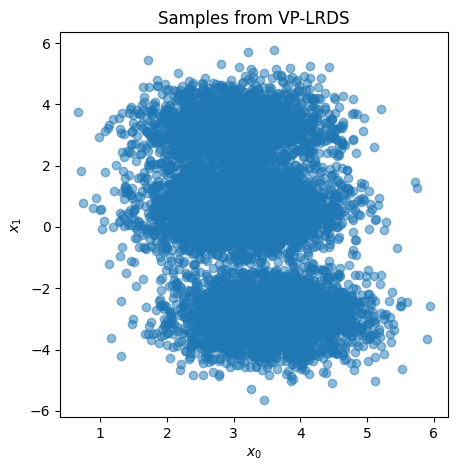

In [30]:
# Display the samples
plt.figure(figsize=(5,5))
plt.scatter(results.samples[:,0].cpu(), results.samples[:,1].cpu(), alpha=0.5)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Samples from VP-LRDS')
plt.show()

Check the metrics of the obtained samples

In [35]:
results.metrics['eval/mode_weight']

Results(samples=tensor([[ 2.2598, -0.5421, -1.4075,  ...,  0.1452, -2.6494,  2.4748],
        [ 3.6510,  1.5816, -1.5163,  ..., -0.0482, -2.7703,  2.0604],
        [ 4.0701, -2.6650,  3.8710,  ..., -0.1144,  1.9190, -0.0840],
        ...,
        [ 2.7114, -0.1994, -1.2551,  ..., -0.4399, -1.9529,  2.0171],
        [ 3.4365, -3.2888,  3.7997,  ...,  0.6669,  1.0888, -1.0354],
        [ 2.3268,  0.0438, -1.3317,  ..., -0.5938, -2.0089,  2.8963]]), weights=tensor([[1.3652e-04],
        [8.4861e-05],
        [9.3246e-05],
        ...,
        [1.5103e-04],
        [1.0370e-04],
        [1.3792e-04]]), log_norm_const_preds={'log_norm_const_is': -0.4887981414794922}, expectation_preds=None, ts=tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300